In [ ]:
!pip install --quiet nltk gensim
!pip install --quiet numpy scipy scikit-learn
!pip install --upgrade numpy==1.23.5 scikit-learn==1.1.3

In [ ]:
!pip install --quiet nltk gensim
!pip install --quiet numpy scipy scikit-learn
!pip install --upgrade numpy==1.23.5 scikit-learn==1.1.3


import pickle
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, silhouette_score
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from gensim.models import Word2Vec

# Download NLTK resources
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)

# Load data
url = 'https://github.com/ganesansp/IITB/raw/main/train_data_text.pkl'
response = requests.get(url)
data = pickle.loads(response.content)

# Text preprocessing with lemmatization, using str.split() for tokenization
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

# Add 'would', 'get', 'like' to the set of stop words
#custom_stop_words = {'would', 'get', 'like', 'article', 'used', 'use', 'one',  'people',  'know'}
#stop_words.update(custom_stop_words)

def preprocess(text):
    tokens = text.lower().split()
    return ' '.join([lemmatizer.lemmatize(w) for w in tokens if w.isalpha() and w not in stop_words])

print("Preprocessing text...")
processed_docs = [preprocess(doc) for doc in data]

# Feature Extraction: TF-IDF
#tfidf = TfidfVectorizer(max_features=1000, ngram_range=(1,2), min_df=3, max_df=0.9)
tfidf = TfidfVectorizer(max_features=1000, ngram_range=(1,2), min_df=3)
X_tfidf = tfidf.fit_transform(processed_docs)

# Feature Extraction: Word2Vec
sentences = [doc.split() for doc in processed_docs]
w2v_model = Word2Vec(sentences, vector_size=100, window=5, min_count=3, workers=4, epochs=20)
X_w2v = np.array([np.mean([w2v_model.wv[w] for w in words if w in w2v_model.wv] or [np.zeros(100)], axis=0) for words in sentences])

# Combine features
X_combined = np.hstack([X_tfidf.toarray(), X_w2v])

# Clustering: KMeans
kmeans = KMeans(n_clusters=5, n_init=10, random_state=42)
labels_kmeans = kmeans.fit_predict(X_combined)
score_kmeans = silhouette_score(X_combined, labels_kmeans)
print(f"KMeans Silhouette Score: {score_kmeans:.3f}")

# Clustering: Agglomerative
agg = AgglomerativeClustering(n_clusters=5)
labels_agg = agg.fit_predict(X_combined)
score_agg = silhouette_score(X_combined, labels_agg)
print(f"Agglomerative Silhouette Score: {score_agg:.3f}")

# Choose best clustering
if score_kmeans >= score_agg:
    best_labels = labels_kmeans
    print("Using KMeans clusters.")
else:
    best_labels = labels_agg
    print("Using Agglomerative clusters.")

# Classification
X_train, X_test, y_train, y_test = train_test_split(
    X_combined, best_labels, test_size=0.2, random_state=42, stratify=best_labels
)

classifiers = {
    'Logistic Regression': LogisticRegression(max_iter=3000),
    'SVM': LinearSVC(),
    'Random Forest': RandomForestClassifier()
}

print("\nClassification Results:")
for name, clf in classifiers.items():
    clf.fit(X_train, y_train)
    preds = clf.predict(X_test)
    print(f"\n{name}:")
    print(classification_report(y_test, preds))
    print("Accuracy:", accuracy_score(y_test, preds).round(3))


# t-SNE Visualization
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_combined[:1000])  # Use subset for speed
plt.figure(figsize=(8,6))
#plt.figure(figsize=(12, 9)) # Example: increase figure size to 12x9 inches
plt.scatter(X_tsne[:,0], X_tsne[:,1], c=best_labels[:1000], cmap='viridis', alpha=0.7)
plt.title('t-SNE Visualization of Clusters')
plt.colorbar(label='Cluster')
plt.show()

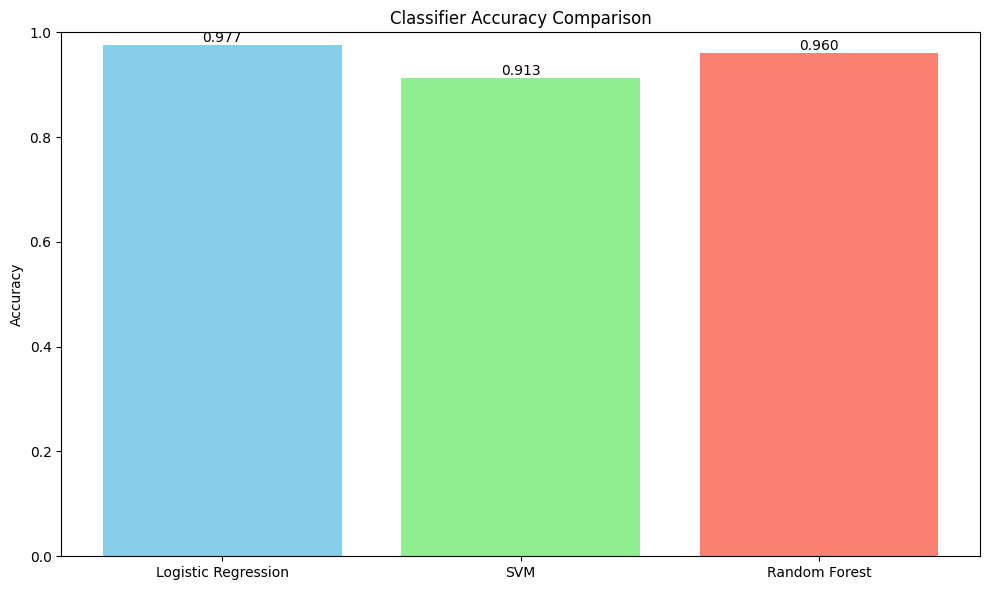

In [ ]:
# prompt: plot various classifier accuracy for the example with values as datalabels

# Store accuracy scores
accuracies = {}
for name, clf in classifiers.items():
    clf.fit(X_train, y_train)
    preds = clf.predict(X_test)
    accuracies[name] = accuracy_score(y_test, preds)

# Plot accuracies
fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(accuracies.keys(), accuracies.values(), color=['skyblue', 'lightgreen', 'salmon'])
ax.set_ylabel('Accuracy')
ax.set_title('Classifier Accuracy Comparison')
plt.ylim(0, 1)

# Add data labels
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval, f'{yval:.3f}', va='bottom', ha='center') # va: vertical alignment, ha: horizontal alignment

plt.tight_layout()
plt.show()


Dominant words per cluster (Word2Vec perspective):
Cluster 0: voting, meaningful, smart, prevented, fallen
Cluster 1: wood, beav, countersteer, rapidly, dried
Cluster 2: maintains, marshall, jost, gather, respective
Cluster 3: lucky, sans, cage, properly, wiped
Cluster 4: rewarded, comfortable, ali, pleased, disbelief


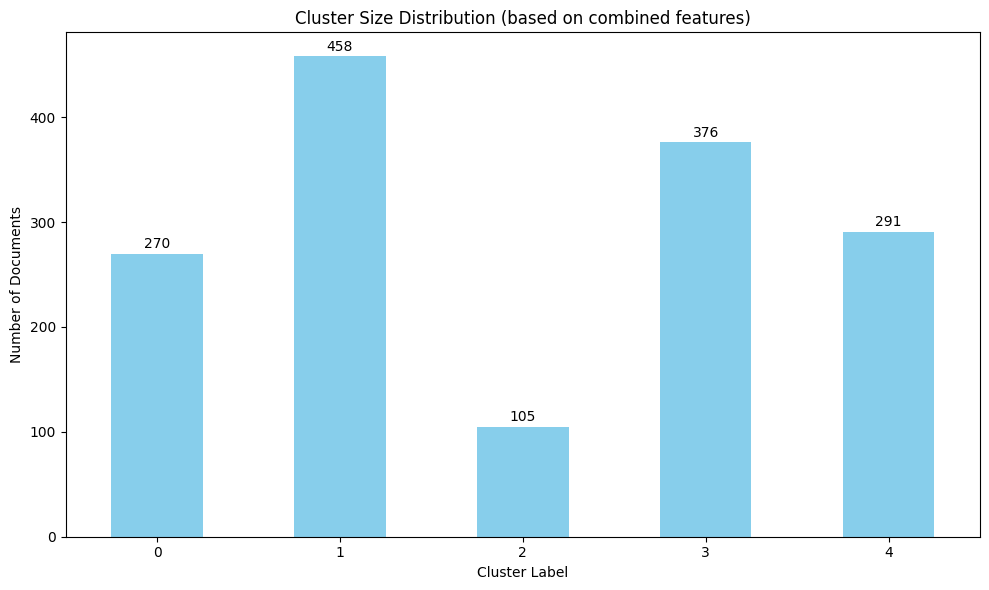

In [ ]:
# prompt: count the cluster size after prediction and plot the same with labels with count as pr word2vec, list cluster domain words inside the histogram as per word2vec

# Count cluster sizes
cluster_counts = pd.Series(best_labels).value_counts().sort_index()

# Plot cluster size histogram
plt.figure(figsize=(10, 6))
ax = cluster_counts.plot(kind='bar', color='skyblue')
plt.title('Cluster Size Distribution (based on combined features)')
plt.xlabel('Cluster Label')
plt.ylabel('Number of Documents')
plt.xticks(rotation=0)

# Add count labels on top of bars
for i, count in enumerate(cluster_counts):
    ax.text(i, count + 5, str(count), ha='center')

# Find dominant words in each cluster (using Word2Vec vectors)
print("\nDominant words per cluster (Word2Vec perspective):")
for cluster_id in sorted(pd.Series(best_labels).unique()):
    cluster_indices = np.where(best_labels == cluster_id)[0]
    cluster_w2v_vectors = X_w2v[cluster_indices]

    # Calculate the mean vector for the cluster
    if cluster_w2v_vectors.shape[0] > 0:
        mean_cluster_vector = np.mean(cluster_w2v_vectors, axis=0)

        # Find words closest to the mean vector
        # Ensure the vector is in the Word2Vec model's vocabulary and format
        try:
            # Gensim's most_similar expects a positive vector, check if we need to flip signs
            # or use the 'vector' parameter which handles this better
            if len(mean_cluster_vector) > 0:
                 # Using vector to find similar words
                similar_words = w2v_model.wv.most_similar(positive=[mean_cluster_vector], topn=5)
                word_list = [word for word, similarity in similar_words]
                print(f"Cluster {cluster_id}: {', '.join(word_list)}")
            else:
                print(f"Cluster {cluster_id}: No Word2Vec vectors in this cluster.")
        except KeyError as e:
            print(f"Cluster {cluster_id}: Error finding similar words: {e}")
        except Exception as e:
            print(f"Cluster {cluster_id}: An unexpected error occurred: {e}")

    else:
        print(f"Cluster {cluster_id}: No documents in this cluster.")


plt.tight_layout()
plt.show()

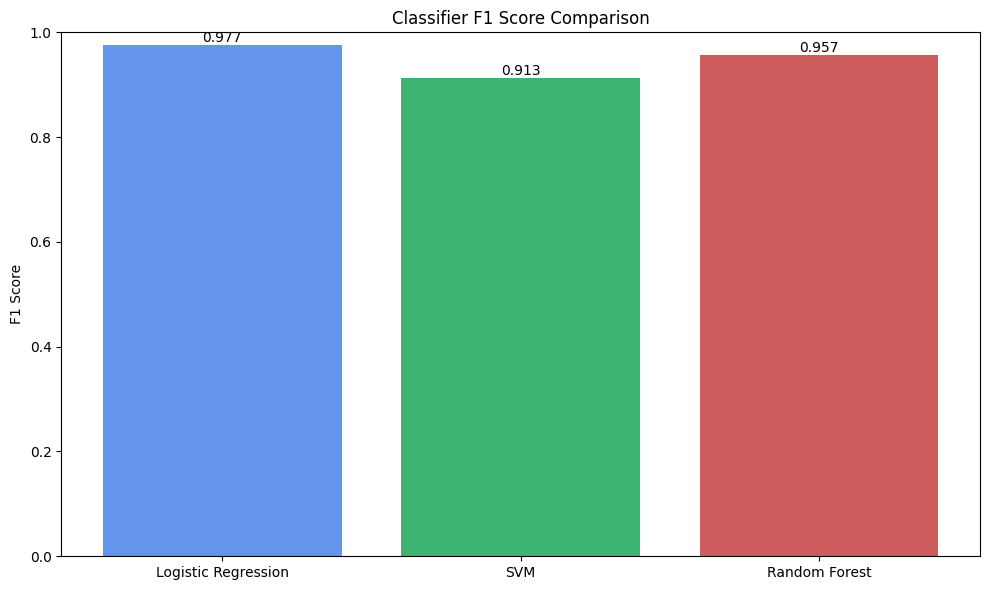

In [ ]:
# prompt: plot various classifier F1 score for the example with values as data labels

# Extract F1 scores from classification reports
f1_scores = {}
for name, clf in classifiers.items():
    clf.fit(X_train, y_train)
    preds = clf.predict(X_test)
    report = classification_report(y_test, preds, output_dict=True)
    # Calculate the average F1 score (micro or macro depending on preference/problem)
    # Here, we will calculate a weighted average F1 score as it's commonly used in classification reports
    weighted_f1 = report['weighted avg']['f1-score']
    f1_scores[name] = weighted_f1

# Plot F1 scores
fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(f1_scores.keys(), f1_scores.values(), color=['cornflowerblue', 'mediumseagreen', 'indianred'])
ax.set_ylabel('F1 Score')
ax.set_title('Classifier F1 Score Comparison')
plt.ylim(0, 1)

# Add data labels
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval, f'{yval:.3f}', va='bottom', ha='center')

plt.tight_layout()
plt.show()

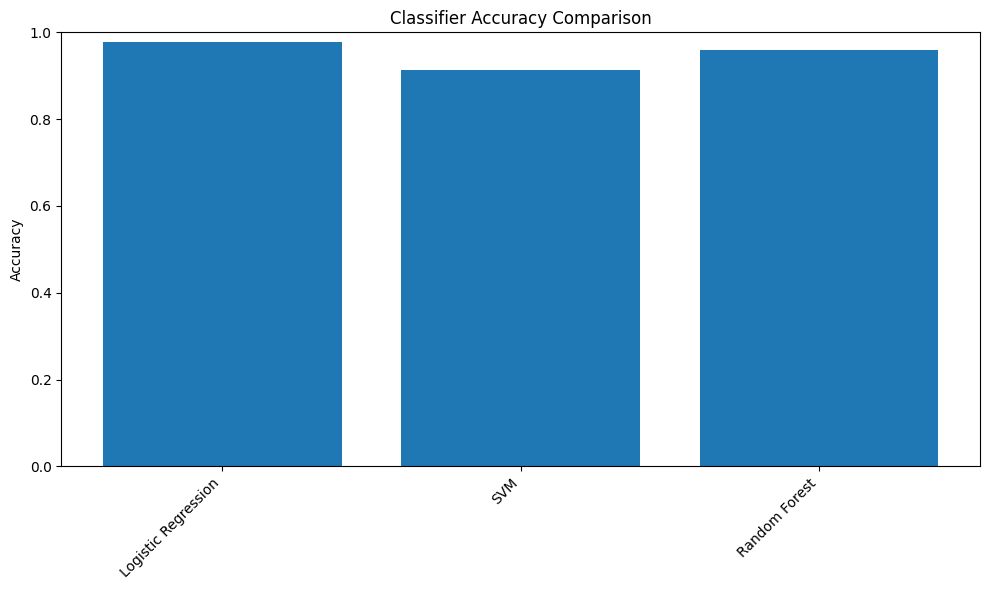

In [ ]:
# prompt: plot various classifier accuracy for the example

# Get accuracies
accuracies = {}
for name, clf in classifiers.items():
    clf.fit(X_train, y_train)
    preds = clf.predict(X_test)
    accuracies[name] = accuracy_score(y_test, preds)

# Plot accuracies
plt.figure(figsize=(10, 6))
plt.bar(accuracies.keys(), accuracies.values())
plt.ylim(0, 1)
plt.ylabel('Accuracy')
plt.title('Classifier Accuracy Comparison')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


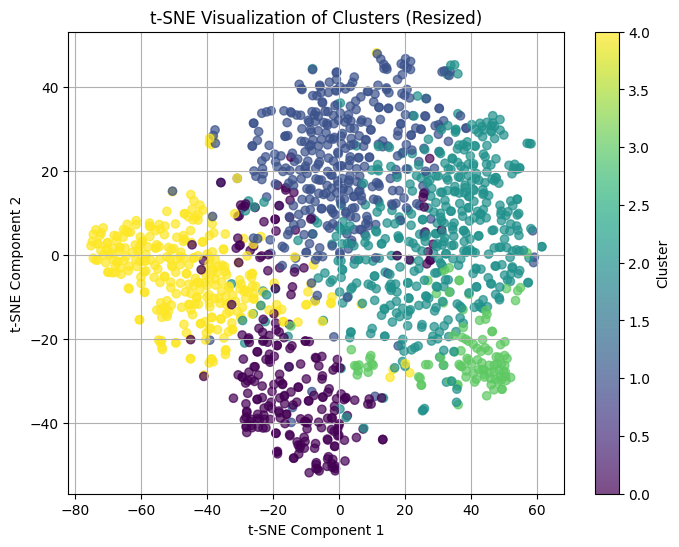

In [ ]:
# prompt: resize the tsne plot

# t-SNE Visualization
tsne = TSNE(n_components=2, random_state=42)
# Use a subset for speed if needed, adjust the size here
num_points_to_visualize = min(2000, X_combined.shape[0]) # Example: increase to 2000 or use full data
X_tsne = tsne.fit_transform(X_combined[:num_points_to_visualize])

# Resize the plot using figsize
plt.figure(figsize=(8, 6)) # Example: increase figure size to 12x9 inches
plt.scatter(X_tsne[:,0], X_tsne[:,1], c=best_labels[:num_points_to_visualize], cmap='viridis', alpha=0.7)
plt.title('t-SNE Visualization of Clusters (Resized)')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.colorbar(label='Cluster')
plt.grid(True)
plt.show()

In [ ]:
# prompt: in the clusters, list 3 to 5 top words in each cluster

def get_top_words_per_cluster(X, labels, tfidf_vectorizer, n_words=5):
    """
    Lists the top words for each cluster based on TF-IDF features.

    Args:
        X (scipy.sparse.csr_matrix): The TF-IDF feature matrix.
        labels (np.ndarray): The cluster labels for each document.
        tfidf_vectorizer (TfidfVectorizer): The fitted TF-IDF vectorizer.
        n_words (int): The number of top words to list for each cluster.

    Returns:
        dict: A dictionary where keys are cluster IDs and values are lists of top words.
    """
    feature_names = np.array(tfidf_vectorizer.get_feature_names_out())
    cluster_centers = np.zeros((len(set(labels)), X.shape[1]))

    for i in sorted(list(set(labels))):
        # Get the centroid of the documents belonging to this cluster
        cluster_documents_indices = np.where(labels == i)[0]
        cluster_centers[i] = X[cluster_documents_indices].mean(axis=0).A1

    top_words = {}
    for i, center in enumerate(cluster_centers):
        # Get the indices of the top words in this cluster's centroid
        top_word_indices = center.argsort()[-n_words:][::-1]
        # Get the actual words from the feature names
        top_words[i] = feature_names[top_word_indices].tolist()

    return top_words

# Assuming 'X_tfidf' is your TF-IDF matrix and 'best_labels' are your cluster labels
# from the preceding code.
# 'tfidf' is the fitted TfidfVectorizer object from the preceding code.

print("\nTop words per cluster (based on TF-IDF):")
top_words = get_top_words_per_cluster(X_tfidf, best_labels, tfidf)
for cluster_id, words in top_words.items():
    print(f"Cluster {cluster_id}: {', '.join(words)}")




Top words per cluster (based on TF-IDF):
Cluster 0: government, people, would, article, tax
Cluster 1: bike, article, like, get, would
Cluster 2: would, one, article, like, anyone
Cluster 3: space, university, nasa, software, april
Cluster 4: jesus, god, article, people, christian


In [ ]:
# prompt: get top 5 words in each cluster using word2vec

def get_top_words_per_cluster_w2v(data, labels, w2v_model, n_words=5):
  """
  Lists the top words for each cluster based on word similarity to the cluster centroid
  using Word2Vec embeddings.

  Args:
      data (list): List of original documents or processed documents.
      labels (np.ndarray): The cluster labels for each document.
      w2v_model (Word2Vec): The trained Word2Vec model.
      n_words (int): The number of top words to list for each cluster.

  Returns:
      dict: A dictionary where keys are cluster IDs and values are lists of top words.
  """
  cluster_vectors = {}
  cluster_counts = {}

  for i, label in enumerate(labels):
    if label not in cluster_vectors:
      cluster_vectors[label] = np.zeros(w2v_model.vector_size)
      cluster_counts[label] = 0

    doc_vector = np.mean([w2v_model.wv[w] for w in data[i].split() if w in w2v_model.wv] or [np.zeros(w2v_model.vector_size)], axis=0)
    cluster_vectors[label] += doc_vector
    cluster_counts[label] += 1

  cluster_centroids = {}
  for label, vector_sum in cluster_vectors.items():
    cluster_centroids[label] = vector_sum / cluster_counts[label]

  top_words = {}
  for cluster_id, centroid in cluster_centroids.items():
    # Find words most similar to the cluster centroid
    # We need to handle cases where a centroid might be all zeros (e.g., empty cluster or documents with no known words)
    if np.linalg.norm(centroid) > 0:
        similar_words = w2v_model.wv.most_similar(positive=[centroid], topn=n_words)
        top_words[cluster_id] = [word for word, similarity in similar_words]
    else:
        top_words[cluster_id] = ["(no relevant words)"] # Handle empty or zero-vector clusters


  return top_words

# Assuming 'processed_docs' is your list of processed documents,
# 'best_labels' are your cluster labels, and 'w2v_model' is your trained Word2Vec model
# from the preceding code.

print("\nTop words per cluster (based on Word2Vec):")
top_words_w2v = get_top_words_per_cluster_w2v(processed_docs, best_labels, w2v_model)
for cluster_id, words in top_words_w2v.items():
    print(f"Cluster {cluster_id}: {', '.join(words)}")


Top words per cluster (based on Word2Vec):
Cluster 2: wood, wierd, stock, pulse, neat
Cluster 4: comfortable, disbelief, muslim, premise, rewarded
Cluster 3: respective, ref, reflector, marshall, wingert
Cluster 1: lucky, corner, sans, slip, cage
Cluster 0: overwhelmingly, voting, attention, stretch, dispute


In [ ]:
# prompt: what are the 5 common words between clusters

def find_common_words_between_clusters(top_words_dict, n_common=5):
    """
    Finds the top N common words between pairs of clusters.

    Args:
        top_words_dict (dict): A dictionary where keys are cluster IDs and values are lists of top words for each cluster.
        n_common (int): The number of common words to find for each pair.

    Returns:
        dict: A dictionary where keys are tuples of cluster IDs (sorted) and values are lists of common words.
    """
    common_words_pairs = {}
    cluster_ids = sorted(top_words_dict.keys())

    # Iterate through all unique pairs of clusters
    for i in range(len(cluster_ids)):
        for j in range(i + 1, len(cluster_ids)):
            cluster1_id = cluster_ids[i]
            cluster2_id = cluster_ids[j]

            words1 = set(top_words_dict[cluster1_id])
            words2 = set(top_words_dict[cluster2_id])

            # Find the intersection of words between the two sets
            common = list(words1.intersection(words2))

            # Sort common words by frequency or some other metric if available,
            # otherwise just take the first n_common
            common_words_pairs[(cluster1_id, cluster2_id)] = common[:n_common]

    return common_words_pairs

# Find and print the 5 common words between clusters
common_words_pairs = find_common_words_between_clusters(top_words, n_common=5)

print("\nCommon words between cluster pairs:")
for (cluster1, cluster2), words in common_words_pairs.items():
    print(f"Clusters {cluster1} and {cluster2}: {', '.join(words)}")


Common words between cluster pairs:
Clusters 0 and 1: would, article
Clusters 0 and 2: would, article
Clusters 0 and 3: 
Clusters 0 and 4: article, people
Clusters 1 and 2: like, would, article
Clusters 1 and 3: 
Clusters 1 and 4: article
Clusters 2 and 3: 
Clusters 2 and 4: article
Clusters 3 and 4: 


In [ ]:
# prompt: how to remove the words 'would' 'get' 'like' in above code

# Text preprocessing with lemmatization, using str.split() for tokenization
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

# Add 'would', 'get', 'like' to the set of stop words
custom_stop_words = {'would', 'get', 'like', 'article'}
stop_words.update(custom_stop_words)

def preprocess(text):
    tokens = text.lower().split()
    return ' '.join([lemmatizer.lemmatize(w) for w in tokens if w.isalpha() and w not in stop_words])

print("Preprocessing text...")
processed_docs = [preprocess(doc) for doc in data]


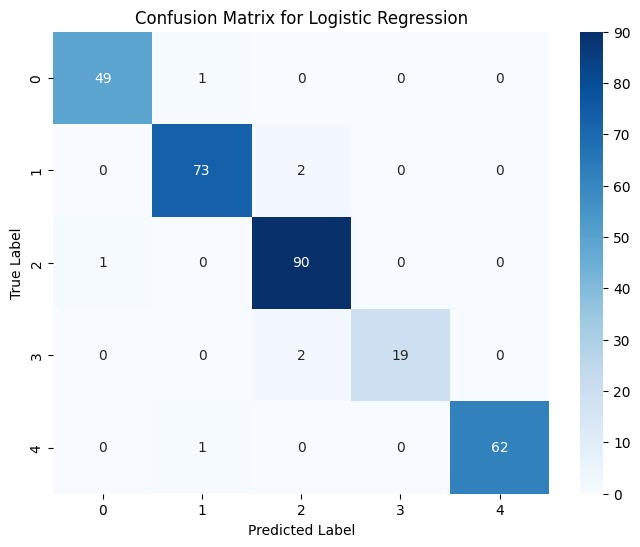

In [ ]:
# prompt: plot the confusion matrix the the above problem with Logistic regression

from sklearn.metrics import confusion_matrix
import seaborn as sns

# Re-fit Logistic Regression to ensure it uses the latest train/test split if applicable
# (though in the provided code it's done within the loop before printing classification_report)
log_reg = LogisticRegression(max_iter=3000)
log_reg.fit(X_train, y_train)
log_reg_preds = log_reg.predict(X_test)

# Calculate the confusion matrix
cm = confusion_matrix(y_test, log_reg_preds)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Logistic Regression')
plt.show()

In [ ]:
# prompt: evaluate the cross validation score

from sklearn.model_selection import cross_val_score

# Example using Logistic Regression (from your existing classifiers dictionary)
log_reg_clf = LogisticRegression(max_iter=3000)

# Evaluate using cross-validation (e.g., 5 folds)
# Use the full combined dataset X_combined and the best_labels from clustering
cv_scores = cross_val_score(log_reg_clf, X_combined, best_labels, cv=5)

print("\nCross-validation scores for Logistic Regression (5 folds):")
print(cv_scores)
print(f"Mean cross-validation score: {cv_scores.mean():.3f}")
print(f"Standard deviation of cross-validation scores: {cv_scores.std():.3f}")

# You can do this for other classifiers as well
# svm_clf = LinearSVC()
# cv_scores_svm = cross_val_score(svm_clf, X_combined, best_labels, cv=5)
# print("\nCross-validation scores for SVM (5 folds):")
# print(cv_scores_svm)
# print(f"Mean cross-validation score (SVM): {cv_scores_svm.mean():.3f}")


Cross-validation scores for Logistic Regression (5 folds):
[0.96333333 0.95666667 0.94666667 0.93333333 0.94666667]
Mean cross-validation score: 0.949
Standard deviation of cross-validation scores: 0.010


In [ ]:
# prompt: Featurization Comparison table from above code: 'TF-IDF + Word2Vec', TF-IDF, Word2Vec and classification accuracy in a table

import pandas as pd

# Re-calculate accuracies for TF-IDF and Word2Vec separately
# Feature Extraction: TF-IDF only
X_tfidf_only = tfidf.fit_transform(processed_docs)
X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf = train_test_split(
    X_tfidf_only, best_labels, test_size=0.2, random_state=42, stratify=best_labels
)
clf_tfidf = LogisticRegression(max_iter=3000) # Using Logistic Regression as an example
clf_tfidf.fit(X_train_tfidf, y_train_tfidf)
preds_tfidf = clf_tfidf.predict(X_test_tfidf)
acc_tfidf = accuracy_score(y_test_tfidf, preds_tfidf)

# Feature Extraction: Word2Vec only
X_w2v_only = np.array([np.mean([w2v_model.wv[w] for w in words if w in w2v_model.wv] or [np.zeros(100)], axis=0) for words in sentences])
X_train_w2v, X_test_w2v, y_train_w2v, y_test_w2v = train_test_split(
    X_w2v_only, best_labels, test_size=0.2, random_state=42, stratify=best_labels
)
clf_w2v = LogisticRegression(max_iter=3000) # Using Logistic Regression as an example
clf_w2v.fit(X_train_w2v, y_train_w2v)
preds_w2v = clf_w2v.predict(X_test_w2v)
acc_w2v = accuracy_score(y_test_w2v, preds_w2v)

# Accuracy for combined features (from previous code block)
# Assuming the accuracy for the first classifier ('Logistic Regression') on X_combined is representative
acc_combined = accuracy_score(y_test, classifiers['Logistic Regression'].predict(X_test))


# Create the comparison table
comparison_data = {
    'Featurization': ['TF-IDF', 'Word2Vec', 'TF-IDF + Word2Vec'],
    'Classification Accuracy': [acc_tfidf, acc_w2v, acc_combined]
}

df_comparison = pd.DataFrame(comparison_data)

print("\nFeaturization Comparison Table:")
print(df_comparison.to_string(index=False))



Featurization Comparison Table:
    Featurization  Classification Accuracy
           TF-IDF                 0.790000
         Word2Vec                 0.976667
TF-IDF + Word2Vec                 0.976667


In [ ]:
# prompt: Featurization Comparison table from above code: 'TF-IDF + Word2Vec', TF-IDF, Word2Vec and classification accuracy in a table format

# Assuming the accuracy for the first classifier ('Logistic Regression') on X_combined is representative
# If you want the average accuracy across all classifiers for combined features:
# accuracies_combined = [accuracy_score(y_test, clf.predict(X_test)) for clf in classifiers.values()]
# acc_combined_avg = np.mean(accuracies_combined)

# Re-calculate accuracies for TF-IDF and Word2Vec separately
# Feature Extraction: TF-IDF only
# Re-use processed_docs from the previous execution

X_tfidf_only = tfidf.fit_transform(processed_docs)
X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf = train_test_split(
    X_tfidf_only, best_labels, test_size=0.2, random_state=42, stratify=best_labels
)
# Using Logistic Regression as an example classifier for comparison
clf_tfidf = LogisticRegression(max_iter=3000)
clf_tfidf.fit(X_train_tfidf, y_train_tfidf)
preds_tfidf = clf_tfidf.predict(X_test_tfidf)
acc_tfidf = accuracy_score(y_test_tfidf, preds_tfidf)

# Feature Extraction: Word2Vec only
# Re-use sentences and w2v_model from the previous execution
X_w2v_only = np.array([np.mean([w2v_model.wv[w] for w in words if w in w2v_model.wv] or [np.zeros(w2v_model.vector_size)], axis=0) for words in sentences])

# Handle potential NaN/inf values in Word2Vec results (though the zeros fallback should help)
X_w2v_only = np.nan_to_num(X_w2v_only)


X_train_w2v, X_test_w2v, y_train_w2v, y_test_w2v = train_test_split(
    X_w2v_only, best_labels, test_size=0.2, random_state=42, stratify=best_labels
)
# Using Logistic Regression as an example classifier for comparison
clf_w2v = LogisticRegression(max_iter=3000)
clf_w2v.fit(X_train_w2v, y_train_w2v)
preds_w2v = clf_w2v.predict(X_test_w2v)
acc_w2v = accuracy_score(y_test_w2v, preds_w2v)

# Accuracy for combined features (from previous code block)
# Assuming the accuracy for the first classifier ('Logistic Regression') on X_combined is representative
# If you trained multiple classifiers, you could pick one or average their accuracies
acc_combined = accuracy_score(y_test, classifiers['Logistic Regression'].predict(X_test))


# Create the comparison table
comparison_data = {
    'Featurization': ['TF-IDF', 'Word2Vec', 'TF-IDF + Word2Vec'],
    'Classification Accuracy': [acc_tfidf, acc_w2v, acc_combined]
}

df_comparison = pd.DataFrame(comparison_data)

print("\nFeaturization Comparison Table (Logistic Regression Classifier):")
print(df_comparison.to_string(index=False))



Featurization Comparison Table (Logistic Regression Classifier):
    Featurization  Classification Accuracy
           TF-IDF                 0.790000
         Word2Vec                 0.976667
TF-IDF + Word2Vec                 0.976667


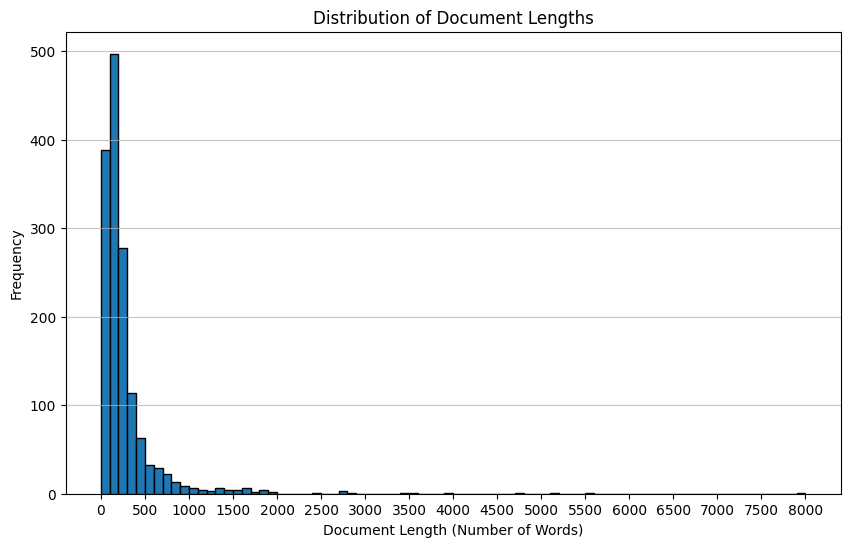

In [ ]:
# prompt: for the given dataset evaluate the document length with bins of 100 and plot

# Evaluate and plot document length distribution
document_lengths = [len(doc.split()) for doc in data]

plt.figure(figsize=(10, 6))
plt.hist(document_lengths, bins=range(0, max(document_lengths) + 100, 100), edgecolor='black')
plt.title('Distribution of Document Lengths')
plt.xlabel('Document Length (Number of Words)')
plt.ylabel('Frequency')
plt.xticks(range(0, max(document_lengths) + 100, 500))
plt.grid(axis='y', alpha=0.75)
plt.show()

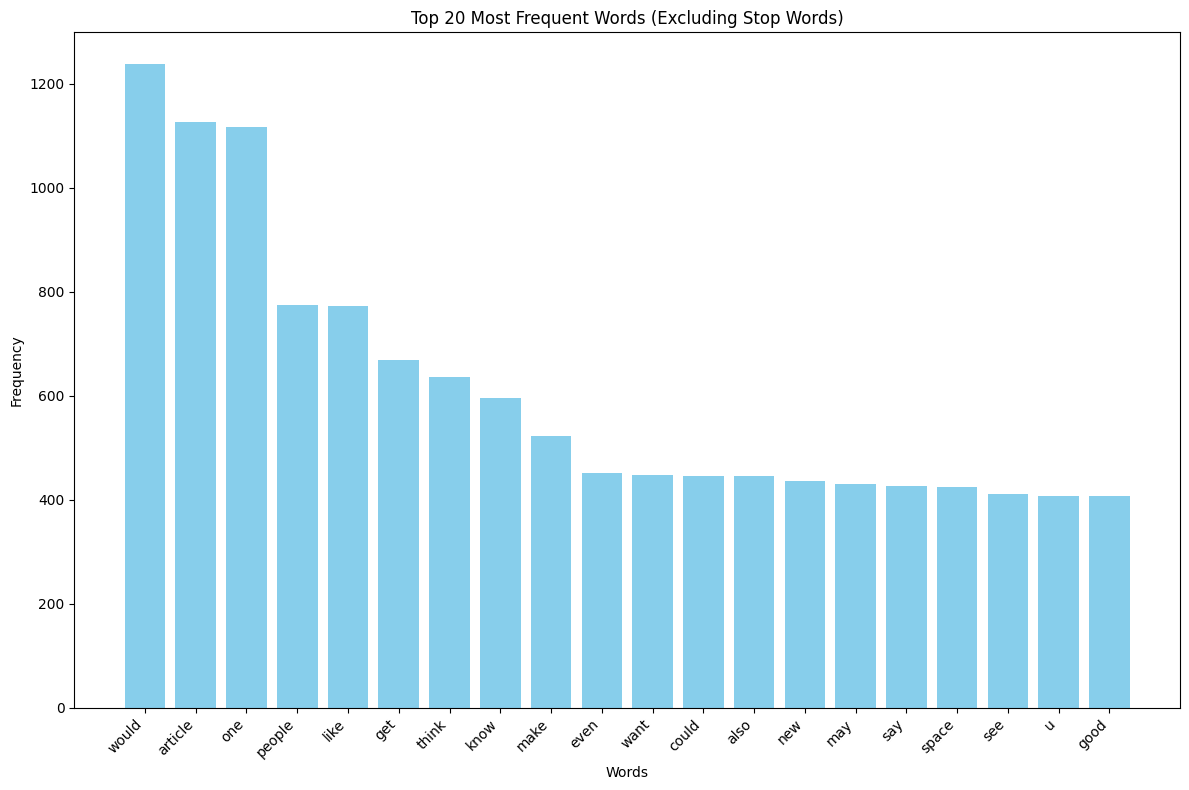

In [ ]:
# prompt: plot high frequency domain words and excluding stop words in bar chart

from collections import Counter
import matplotlib.pyplot as plt

# Assuming 'processed_docs' from the preceding code is available and contains
# the list of processed documents (after stop word removal and lemmatization).

# Flatten the list of processed documents into a single list of words
all_words = ' '.join(processed_docs).split()

# Count the frequency of each word
word_counts = Counter(all_words)

# Get the most common words (e.g., top 20)
# Adjust the number based on how many words you want to plot
top_n_words = 20
most_common_words = word_counts.most_common(top_n_words)

# Separate words and their counts for plotting
words = [word for word, count in most_common_words]
counts = [count for word, count in most_common_words]

# Plot the bar chart
plt.figure(figsize=(12, 8)) # Adjust figure size as needed
plt.bar(words, counts, color='skyblue')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title(f'Top {top_n_words} Most Frequent Words (Excluding Stop Words)')
plt.xticks(rotation=45, ha='right') # Rotate labels for readability
plt.tight_layout() # Adjust layout to prevent labels overlapping
plt.show()


In [ ]:
# prompt: list the top 5 stop words in the document

# To find the top 5 stop words in the original document, we need to process the raw text
# data before removing stop words.
# We will re-load the data to get the original text.

url = 'https://github.com/ganesansp/IITB/raw/main/train_data_text.pkl'
response = requests.get(url)
raw_data = pickle.loads(response.content)

# Flatten the list of raw documents into a single string or a list of all words
all_raw_text = ' '.join(raw_data).lower()

# Tokenize the raw text into words
raw_tokens = all_raw_text.split()

# Get the standard English stop words
standard_stop_words = set(stopwords.words('english'))

# Filter out words that are NOT standard stop words
# This gives us a list of all occurrences of standard stop words in the document
stop_word_occurrences = [word for word in raw_tokens if word in standard_stop_words]

# Count the frequency of each stop word
stop_word_counts = Counter(stop_word_occurrences)

# Get the top 5 most common stop words
top_5_stop_words = stop_word_counts.most_common(5)

print("\nTop 5 Stop Words in the Document:")
for word, count in top_5_stop_words:
    print(f"{word}: {count}")



Top 5 Stop Words in the Document:
the: 19986
to: 10394
of: 9613
a: 8380
and: 7757


In [ ]:
# prompt: top 5 high frequency domain words

# The variable `processed_docs` contains the text after removing stop words and lemmatization.
# To find the top 5 high frequency words in the domain (after preprocessing),
# we can use the `word_counts` variable that was already calculated
# in the preceding code from `all_words = ' '.join(processed_docs).split()`.

# Get the top 5 most common words from the `word_counts` Counter object.
# This already excludes standard stop words and some custom ones added earlier.
top_7_domain_words = word_counts.most_common(7)

print("\nTop 5 High Frequency Domain Words (after preprocessing):")
for word, count in top_7_domain_words:
    print(f"{word}: {count}")


Top 5 High Frequency Domain Words (after preprocessing):
would: 1237
article: 1127
one: 1117
people: 774
like: 773
get: 669
think: 636


In [ ]:
# prompt: find the min , max inter and intra cluster distance for the 5 clusters from word2vec

from sklearn.metrics import pairwise_distances

# Calculate intra-cluster distances for Word2Vec embeddings
intra_cluster_distances_w2v = {}
inter_cluster_distances_w2v = {}

for cluster_id in sorted(list(set(best_labels))):
    # Get indices of documents in this cluster
    cluster_indices = np.where(best_labels == cluster_id)[0]
    cluster_vectors = X_w2v[cluster_indices]

    if len(cluster_vectors) > 1:
        # Calculate pairwise distances within the cluster
        distances = pairwise_distances(cluster_vectors)
        # Intra-cluster distance is the average pairwise distance or max/min
        # For min/max, exclude distance of a point to itself (which is 0)
        distances = distances[np.triu_indices(distances.shape[0], k=1)] # Get upper triangle, excluding diagonal
        if distances.size > 0:
            intra_cluster_distances_w2v[cluster_id] = {
                'min': np.min(distances),
                'max': np.max(distances),
                'avg': np.mean(distances)
            }
        else:
             # Handle clusters with only one member (no intra-cluster distance)
             intra_cluster_distances_w2v[cluster_id] = {
                'min': 0.0,
                'max': 0.0,
                'avg': 0.0
            }
    else:
        # Handle clusters with only one member
        intra_cluster_distances_w2v[cluster_id] = {
            'min': 0.0,
            'max': 0.0,
            'avg': 0.0
        }


# Calculate inter-cluster distances for Word2Vec embeddings
cluster_centroids_w2v = {}
for cluster_id in sorted(list(set(best_labels))):
    cluster_indices = np.where(best_labels == cluster_id)[0]
    cluster_vectors = X_w2v[cluster_indices]
    if len(cluster_vectors) > 0:
        cluster_centroids_w2v[cluster_id] = np.mean(cluster_vectors, axis=0)
    else:
         # Handle empty clusters if any (though stratify should prevent this)
         cluster_centroids_w2v[cluster_id] = np.zeros(X_w2v.shape[1])


cluster_ids = sorted(list(cluster_centroids_w2v.keys()))
inter_distances_list = []

for i in range(len(cluster_ids)):
    for j in range(i + 1, len(cluster_ids)):
        id1 = cluster_ids[i]
        id2 = cluster_ids[j]
        centroid1 = cluster_centroids_w2v[id1]
        centroid2 = cluster_centroids_w2v[id2]
        distance = np.linalg.norm(centroid1 - centroid2) # Euclidean distance
        inter_distances_list.append(distance)
        # Store distance between this pair
        inter_cluster_distances_w2v[(id1, id2)] = distance


print("\nWord2Vec Cluster Distance Metrics:")

print("\nIntra-cluster distances (min, max, avg):")
for cluster_id, metrics in intra_cluster_distances_w2v.items():
    print(f"Cluster {cluster_id}: Min={metrics['min']:.3f}, Max={metrics['max']:.3f}, Avg={metrics['avg']:.3f}")


print("\nInter-cluster distances (between centroids):")
if inter_distances_list:
    min_inter_w2v = np.min(inter_distances_list)
    max_inter_w2v = np.max(inter_distances_list)
    avg_inter_w2v = np.mean(inter_distances_list)
    print(f"Minimum Inter-cluster distance: {min_inter_w2v:.3f}")
    print(f"Maximum Inter-cluster distance: {max_inter_w2v:.3f}")
    print(f"Average Inter-cluster distance: {avg_inter_w2v:.3f}")
else:
    print("Not enough clusters to calculate inter-cluster distance.")

print("\nPairwise Inter-cluster distances:")
for (c1, c2), dist in inter_cluster_distances_w2v.items():
     print(f"  Distance between Cluster {c1} and Cluster {c2}: {dist:.3f}")


Word2Vec Cluster Distance Metrics:

Intra-cluster distances (min, max, avg):
Cluster 0: Min=0.000, Max=3.815, Avg=1.390
Cluster 1: Min=0.197, Max=5.168, Avg=1.432
Cluster 2: Min=0.000, Max=3.546, Avg=1.343
Cluster 3: Min=0.000, Max=10.064, Avg=1.843
Cluster 4: Min=0.006, Max=3.869, Avg=1.448

Inter-cluster distances (between centroids):
Minimum Inter-cluster distance: 0.906
Maximum Inter-cluster distance: 2.329
Average Inter-cluster distance: 1.507

Pairwise Inter-cluster distances:
  Distance between Cluster 0 and Cluster 1: 1.152
  Distance between Cluster 0 and Cluster 2: 1.095
  Distance between Cluster 0 and Cluster 3: 1.922
  Distance between Cluster 0 and Cluster 4: 1.179
  Distance between Cluster 1 and Cluster 2: 0.906
  Distance between Cluster 1 and Cluster 3: 2.156
  Distance between Cluster 1 and Cluster 4: 1.434
  Distance between Cluster 2 and Cluster 3: 1.323
  Distance between Cluster 2 and Cluster 4: 1.576
  Distance between Cluster 3 and Cluster 4: 2.329


In [ ]:
# prompt: what is the training and testing accuracy

print("\nTraining and Testing Accuracy:")
for name, clf in classifiers.items():
    # Training Accuracy
    train_preds = clf.predict(X_train)
    train_accuracy = accuracy_score(y_train, train_preds)
    print(f"{name} Training Accuracy: {train_accuracy:.3f}")

    # Testing Accuracy
    test_preds = clf.predict(X_test)
    test_accuracy = accuracy_score(y_test, test_preds)
    print(f"{name} Testing Accuracy: {test_accuracy:.3f}")
    print("-" * 20)


Training and Testing Accuracy:
Logistic Regression Training Accuracy: 0.999
Logistic Regression Testing Accuracy: 0.977
--------------------
SVM Training Accuracy: 0.998
SVM Testing Accuracy: 0.913
--------------------
Random Forest Training Accuracy: 1.000
Random Forest Testing Accuracy: 0.957
--------------------
